In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib import pyplot

import json

from rbm import RBM, train_rbm
from rbm_utils import loss
from dae import DAE
from utils import dump_models, load_models, min_max_scale_data, display_output, plot_loss

In [5]:
mnist = tf.keras.datasets.mnist.load_data(path="mnist.npz") # returns (x_train, y_train), (x_test, y_test)
x_train, y_train = mnist[0]
x_tset, y_test = mnist[1]

MNIST_NUM_PIXELS = 784 # 28x28
x_train = x_train.reshape(-1,MNIST_NUM_PIXELS, 1)
x_train_full = x_train
x_train = x_train[:int(training_data_size), :]
x_train = np.divide(x_train,255)

x_train = tf.constant(x_train, dtype=tf.float32)
x_train = tf.reshape(x_train, (-1,784))

In [6]:
epochs = int(epochs)
lr_b = 0.01
lr_g = 0.001
models_specs = [
    {
        "visible_dim": 784,
        "hidden_dim": 1000, 
        "num_epochs": epochs, 
        "learning_rate": lr_b, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "visible_dim": 1000,
        "hidden_dim": 500, 
        "num_epochs": epochs, 
        "learning_rate": lr_b, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "visible_dim": 500,
        "hidden_dim": 250, 
        "num_epochs": epochs, 
        "learning_rate": lr_b, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "visible_dim": 250,
        "hidden_dim": 2, 
        "num_epochs": epochs * 3, 
        "learning_rate": lr_g, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]

In [7]:
# model1 = load_models('1_784_1000')[0]
# model2 = load_models('2_1000_500')[0]
# model3 = load_models('3_500_250')[0]
# model4 = load_models('4_250_2')[0]
# models=[model1,model2,model3,model4]
# display_output(x_train, model1, 28,28)

In [8]:
# _, data1 = model1.sample_h(x_train)
# _, data2 = model2.sample_h(data1)
# _, data3 = model3.sample_h(data2)
datas=[x_train]#data1,data2,data3]

In [ ]:
index = 0
data = datas[index]
config = models_specs[index]

def train_layer(data, config):
    # parse config
    visible_dim = config["visible_dim"]
    hidden_dim = config["hidden_dim"]
    num_epochs = config["num_epochs"]
    lr = config["learning_rate"]
    d1 = config["display_dim1"]
    d2 = config["display_dim2"]
    use_gaussian = config["use_gaussian"]
    
    # train RBM
    print(f'Training RBM -> {visible_dim} to {hidden_dim}')
    model, v, v_pred, losses = train_rbm(
        data,
        visible_dim, hidden_dim,
        k=1, 
        num_epochs=num_epochs, batch_size=int(batch_size),
        lr=lr,
        use_gaussian=use_gaussian,
        # pretrained_rbm=models[index]
    )
    
    # display sample output and plot loss
    display_output(data, model, d1, d2)
    # dump_models(f'{index+1}_{visible_dim}_{hidden_dim}', [model])
    return model
train_layer(data, config)

Training RBM -> 784 to 1000


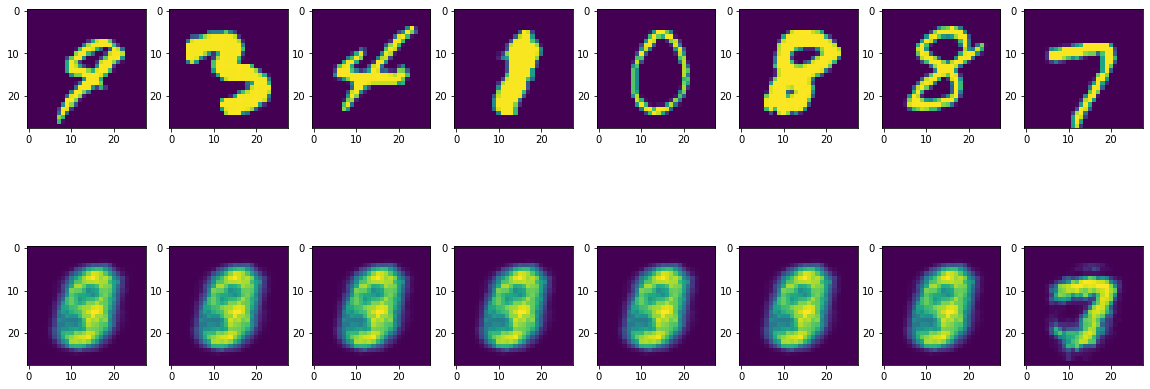

In [ ]:
ae = DAE(models)
display_output(x_train, ae, 28, 28)

In [ ]:
def loss(prediction, label):
    assert prediction.dtype == tf.float32, f'wrong dtype for prediction {prediction.dtype}'
    assert label.dtype == tf.float32, f'wrong dtype for label {prediction.dtype}'

    diff = tf.subtract(prediction, label)
    sq = tf.square(diff)
    return tf.cast(tf.reduce_mean(sq), tf.float32)


epoch 0: 0.0
epoch 10: 0.0
epoch 19: 0.0


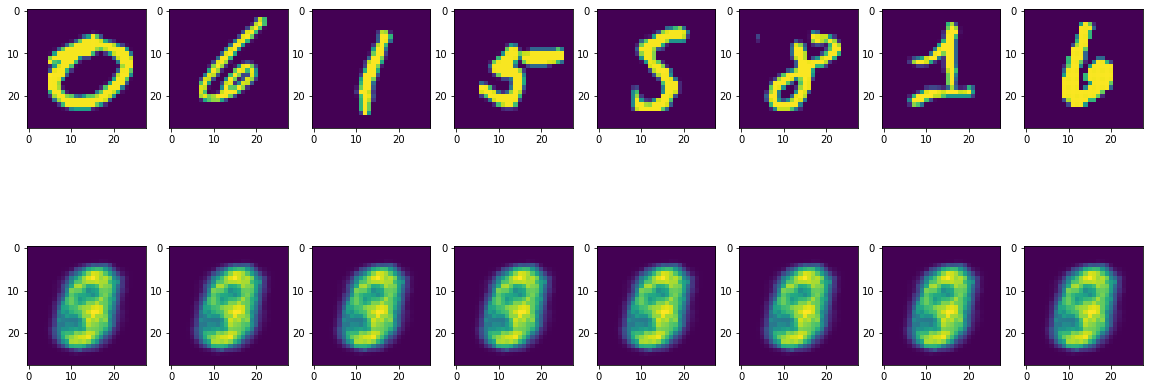

In [ ]:
# fine-tune autoencoder
opt = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
for epoch in range(20):
    losses = []
    loss_ = lambda: loss(ae.predict(x_train), x_train)
    opt.minimize(loss_, [*ae.encoders, *ae.decoders])
    # for val in x_train:
    #     # val = tf.constant(val.T, dtype=tf.float32)
    #     val = tf.reshape(val, (1, -1))
    #     loss_ = lambda: loss(ae.predict(val), val)
    #     opt.minimize(loss_, [*ae.encoders, *ae.decoders])
    #     losses.append(loss_())
    if epoch%10 == 0: print(f'epoch {epoch}: {tf.reduce_sum(losses).numpy()}')
print(f'epoch {epoch}: {tf.reduce_sum(losses).numpy()}')
display_output(x_train, ae, 28, 28)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8f7eba4-1ab3-4397-b00f-0691cd146402' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>